

## Context:

Doctors depend heavily on getting good images so that they can confidently diagnose challenging diseases and conditions. Thus, it's to **make sure** that the images that are captured are good (i.e. patient did not move during acquisition), in service of the doctors who will be interpreting the image. This is one challenge to which we apply machine learning!

## Challenge

**The task is to build a model to predict the quality label of an image.** Given images are of good (label 0), acceptable (label 1) and bad quality (label 2).



## Data

fundus folder consists of two components:

1. 150 .pngs in the "fundus" folder consisting of fundus images of varying image quality
2. a csv containing the image name and quality label



# Step 0: Exploratory Data Analysis

Explore the data and share your insights!

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import torch 
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms, utils
import numpy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/data_dictionary.csv')


data.head()

,image,type,quality
0,129_left.png,fundus,0
1,611_left.png,fundus,0
2,678_left.png,fundus,0
3,678_right.png,fundus,0
4,1096_right.png,fundus,0


In [ ]:
#checking for duplicates
data.drop_duplicates

<bound method DataFrame.drop_duplicates of               image    type  quality
0      129_left.png  fundus        0
1      611_left.png  fundus        0
2      678_left.png  fundus        0
3     678_right.png  fundus        0
4    1096_right.png  fundus        0
..              ...     ...      ...
145   6691_left.png  fundus        1
146   6759_left.png  fundus        1
147   7383_left.png  fundus        1
148  7825_right.png  fundus        1
149  8028_right.png  fundus        1

[150 rows x 3 columns]>

In [ ]:
data.describe()


,quality
count,150.000000
mean,1.000000
std,0.819232
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


# Step 1: Simple Case

Start by developing a model to tell the difference between a good (label 0) image and a bad (label 2) image.

In [ ]:
#performing some transformations
tsfm = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((32,32)),
     transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5))]
)

In [ ]:
class FundusDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file,skiprows = [i for i in range(51, 101) ])
            
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = io.imread(img_name)
        quality = self.data.iloc[idx,2]
        

        if self.transform:
            image = self.transform(np.asarray(image))
            

        sample = {'image': image, 'quality': quality}
        return sample

In [ ]:
fundus_dataset = FundusDataset(csv_file='/content/drive/MyDrive/data_dictionary.csv', root_dir='/content/drive/MyDrive/fundus/', transform=tsfm)

In [ ]:

train_size = int(0.8 * len(fundus_dataset))
test_size = len(fundus_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(fundus_dataset, [train_size, test_size])

In [ ]:
len(fundus_dataset)

100

In [ ]:
classes = ('0','2')

In [ ]:
batch_size = 4
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

0 torch.Size([3, 32, 32]) ()


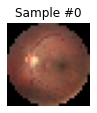

1 torch.Size([3, 32, 32]) ()


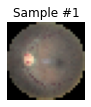

2 torch.Size([3, 32, 32]) ()


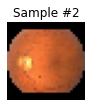

3 torch.Size([3, 32, 32]) ()


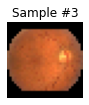

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
fig = plt.figure()

for i in range(len(fundus_dataset)):
    sample = fundus_dataset[i]
    print(i, sample['image'].shape, sample['quality'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    imshow(sample['image'])

    if i == 3:
        plt.show()
        break



In [ ]:
class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = (self.fc3(x))
        return x

net = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)


In [ ]:
NUM_EPOCHS = 5

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['image'], data['quality']
        # inputs will be tensor of size batch_size x 3 x 32 x 32

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = net(inputs)
        # calculate loss for the current mini-batch
        loss = criterion(outputs, labels)
        # backward pass to update my NN weights
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')


[1,    20] loss: 1.074
[2,    20] loss: 1.040
[3,    20] loss: 1.007
[4,    20] loss: 0.976
[5,    20] loss: 0.949
Finished Training


In [ ]:
PATH = '/content/drive/MyDrive/fundus_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data['image'], data['quality']
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 75 %


I have removed the datapoints belonging to the intermediate class and so the total dataset is reduced. The dataset is still balanced and so the model performs decent given the small number of datapoints.

# Step 2: Merged Case

Next, merge the intermediate class (label 1) with the bad class (label 2). Build a model to differentiate between the new merged class (bad and intermediate) and the good class (label 0).


In [ ]:
class FundusDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.data['quality'][101:]=1
        
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = io.imread(img_name)
        quality = self.data.iloc[idx,2]
        

        if self.transform:
            image = self.transform(np.asarray(image))
            

        sample = {'image': image, 'quality': quality}
        return sample

In [ ]:
fundus_dataset = FundusDataset(csv_file='/content/drive/MyDrive/data_dictionary.csv', root_dir='/content/drive/MyDrive/fundus/', transform=tsfm)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
train_size = int(0.8 * len(fundus_dataset))
test_size = len(fundus_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(fundus_dataset, [train_size, test_size])

In [ ]:
classes = ('0','1')

In [ ]:
batch_size = 4
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = (self.fc3(x))
        return x

net = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

In [ ]:
NUM_EPOCHS = 5

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['image'], data['quality']
        # inputs will be tensor of size batch_size x 3 x 32 x 32

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = net(inputs)
        # calculate loss for the current mini-batch
        loss = criterion(outputs, labels)
        # backward pass to update my NN weights
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')


[1,    20] loss: 1.091
[2,    20] loss: 1.028
[3,    20] loss: 0.939
[4,    20] loss: 0.903
[5,    20] loss: 0.859
Finished Training


In [ ]:
PATH = '/content/drive/MyDrive/fundus_net1.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data['image'], data['quality']
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 53 %


I have deployed the same model as in the previous case, but the accuracy has come down. Although this model takes in more datapoints, the data is more imbalanced and biased, which probably could be one of the reason behind the poor performance compared to the first case.

# Step 3: Full Case

In this stage, consider building a model to predict the specific image quality (e.g. 0 OR 1 OR 2). 

In [ ]:
class FundusDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = io.imread(img_name)
        quality = self.data.iloc[idx,2]
        

        if self.transform:
            image = self.transform(np.asarray(image))
            

        sample = {'image': image, 'quality': quality}
        return sample

In [ ]:
fundus_dataset = FundusDataset(csv_file='/content/drive/MyDrive/data_dictionary.csv', root_dir='/content/drive/MyDrive/fundus/', transform=tsfm)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
train_size = int(0.8 * len(fundus_dataset))
test_size = len(fundus_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(fundus_dataset, [train_size, test_size])

In [ ]:
classes = ('0','1','2')

In [ ]:
batch_size = 4
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = (self.fc3(x))
        return x

net = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

In [ ]:
NUM_EPOCHS = 5

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['image'], data['quality']
        # inputs will be tensor of size batch_size x 3 x 32 x 32

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = net(inputs)
        # calculate loss for the current mini-batch
        loss = criterion(outputs, labels)
        # backward pass to update my NN weights
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0
print('Finished Training')

[1,    20] loss: 1.083
[2,    20] loss: 1.016
[3,    20] loss: 0.961
[4,    20] loss: 0.890
[5,    20] loss: 0.866
Finished Training


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data['image'], data['quality']
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 70 %
